In [11]:
%load_ext autoreload
%autoreload 2

here the objective is to fit the logit graph model to multiple different graph domains and then visualize the original vs fitted graphs

In [12]:

import sys
import os
sys.path.append('../')

#Graph imports
import src.graph as graph
import src.logit_estimator as estimator
import src.utils as utils
import src.model_selection as model_selection
import src.gic as gic
import src.param_estimator as pe
import src.graph as graph
import src.model_selection as ms

# usual imports
import matplotlib.pyplot as plt
import pickle
import math
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import gaussian_kde
import numpy as np
import pandas as pd
import seaborn as sns
import gc
import random
import networkx as nx
from numpy import errstate

from IPython.display import display
from pyvis.network import Network
from mpl_toolkits.axes_grid1 import make_axes_locatable


### Fitting single graph

Loading the different graphs into a networkx graph

In [13]:
def load_facebook_graph(data_dir, graph_id):
    """
    Loads a Facebook graph from the specified directory and graph ID.

    Args:
        data_dir (str): The directory where the facebook data is stored.
        graph_id (int): The ID of the graph to load.

    Returns:
        networkx.Graph: The loaded graph as a networkx Graph object.
    """
    edge_file = os.path.join(data_dir, f"{graph_id}.edges")
    
    G = nx.Graph()
    
    with open(edge_file, 'r') as f:
        for line in f:
            # The files are space-separated, so we split the line
            # and convert the node IDs to integers.
            u, v = map(int, line.strip().split())
            G.add_edge(u, v)
            
    return G


data_directory = f'../data/misc/facebook'
ids = [0, 107, 348, 414, 686, 698, 1684, 1912, 3437, 3980]
graphs = []
for id in ids:
    graphs.append(load_facebook_graph(data_directory, id))
    print(f"Graph {id} loaded successfully. Edges: {graphs[-1].number_of_edges()}, Nodes: {graphs[-1].number_of_nodes()}")

Graph 0 loaded successfully. Edges: 2519, Nodes: 333
Graph 107 loaded successfully. Edges: 26749, Nodes: 1034
Graph 348 loaded successfully. Edges: 3192, Nodes: 224
Graph 414 loaded successfully. Edges: 1693, Nodes: 150
Graph 686 loaded successfully. Edges: 1656, Nodes: 168
Graph 698 loaded successfully. Edges: 270, Nodes: 61
Graph 1684 loaded successfully. Edges: 14024, Nodes: 786
Graph 1912 loaded successfully. Edges: 30025, Nodes: 747
Graph 3437 loaded successfully. Edges: 4813, Nodes: 534
Graph 3980 loaded successfully. Edges: 146, Nodes: 52



==================== Processing Graph ====================
Original graph - Nodes: 333, Edges: 2519
Running generation...


Optimizing Graph:   0%|          | 3/3000 [00:00<01:03, 47.54it/s, GIC=21.9299, Spectrum Diff=401.7337, Patience=0/200, Edges=0.0/2519.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 5)
	 Best Spectrum Diff: inf
	 Patience: 0/200
	 Current edges: 0.0 (Real edges: 2519.0)


Optimizing Graph:  34%|███▎      | 1008/3000 [00:27<00:48, 40.83it/s, GIC=21.6805, Spectrum Diff=399.9156, Patience=0/200, Edges=5.0/2519.0]

iteration: 1000
	 Current GIC (KL): 21.6805 (Threshold: 5)
	 Best Spectrum Diff: 399.9156
	 Patience: 0/200
	 Current edges: 5.0 (Real edges: 2519.0)


Optimizing Graph:  67%|██████▋   | 2008/3000 [00:55<00:23, 41.65it/s, GIC=21.6726, Spectrum Diff=398.2985, Patience=0/200, Edges=10.0/2519.0]

iteration: 2000
	 Current GIC (KL): 21.6726 (Threshold: 5)
	 Best Spectrum Diff: 398.2985
	 Patience: 0/200
	 Current edges: 10.0 (Real edges: 2519.0)


Optimizing Graph: 100%|██████████| 3000/3000 [01:24<00:00, 35.41it/s, GIC=15.6505, Spectrum Diff=396.4495, Patience=0/200, Edges=16.0/2519.0]


iteration: 3000
	 Current GIC (KL): 15.6505 (Threshold: 5)
	 Best Spectrum Diff: 396.4495
	 Patience: 0/200
	 Current edges: 16.0 (Real edges: 2519.0)
Max iterations (3000) reached. Stopping.

--- Stopping Condition Met ---
- Reason: Max iterations (3000) reached.

--- Results ---
- Best iteration found: 2971
- Best spectrum difference: 396.4495
- Edges in best graph: 16.0 (Real graph edges: 2519.0)
Finished generation.
Fitting successful - GIC: 15.6505, Best iteration: 2971
Fitted graph - Nodes: 333, Edges: 16

--- Fitting Metadata ---


,Value
original_nodes,333
original_edges,2519
fit_success,True
error_message,None
sigma,-5.071367
gic_value,15.650502
best_iteration,2971
fitted_nodes,333
fitted_edges,16
spectrum_diffs,"[401.73374267044073, 401.73374267044073, 401.7..."


An error occurred during the example run: 15


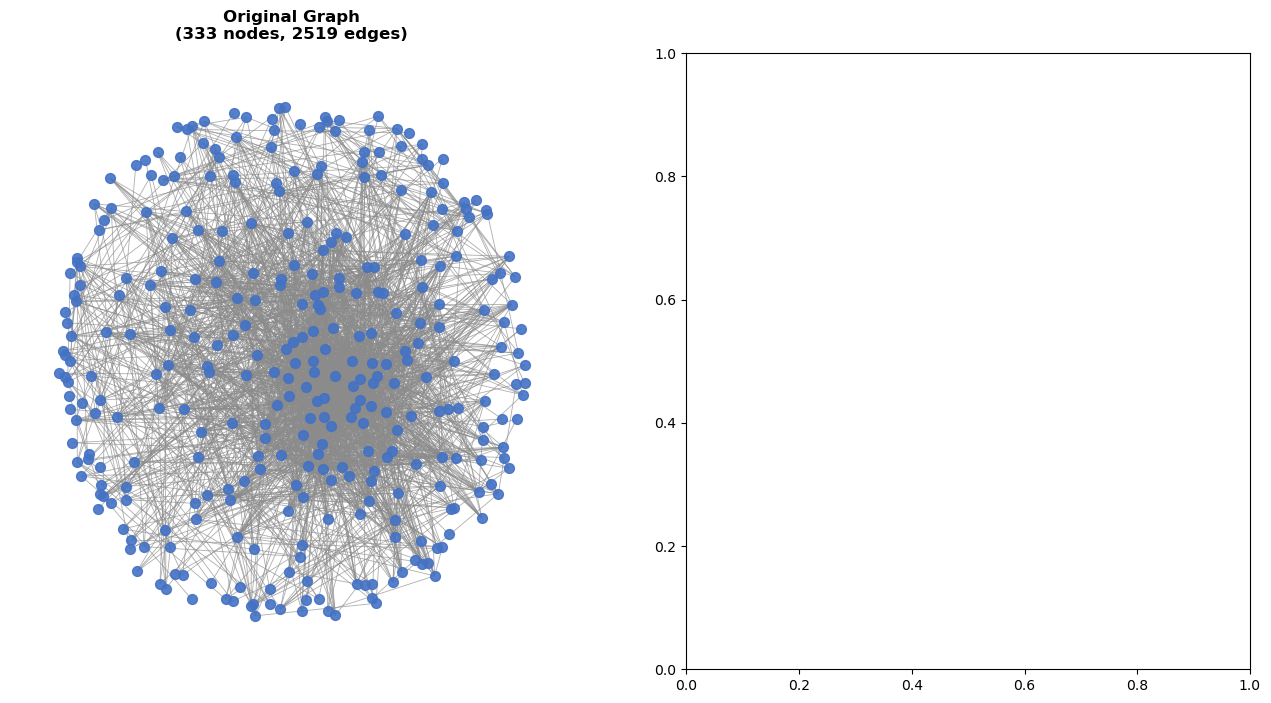

In [20]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import gc
import pandas as pd
from IPython.display import display



def get_logit_graph(real_graph, d, n_iteration, warm_up, patience, dist_type='KL', edge_delta=None, min_gic_threshold=None, verbose=True):
   """
   Estimates parameters, generates a graph using the Logit Graph model,
   and calculates GIC, allowing for different convergence criteria.
   (This function is from your provided code)
   """
   if isinstance(real_graph, nx.Graph):
       real_graph = nx.to_numpy_array(real_graph)

   est = estimator.LogitRegEstimator(real_graph, d=d)
   features, labels = est.get_features_labels()
   result, params, pvalue = est.estimate_parameters(l1_wt=1, alpha=0, features=features, labels=labels)
   sigma = params[0]

   n = real_graph.shape[0]
   graph_model = graph.GraphModel(n=n, d=d, sigma=sigma)

   print(f"Running generation...")
   graphs, spec, spectrum_diffs, best_iteration, best_graph_arr = graph_model.populate_edges_spectrum_min_gic(
        max_iterations=n_iteration,
        patience=patience,
        real_graph=real_graph,
        edge_delta=edge_delta,
        min_gic_threshold=min_gic_threshold,
        gic_dist_type=dist_type,
        verbose=verbose,
    )
   print(f"Finished generation.")

   real_edges = np.sum(real_graph) / 2
   edge_diffs = [abs(np.sum(g) / 2 - real_edges) for g in graphs]

   best_graph_nx = nx.from_numpy_array(best_graph_arr)
   gic_value = gic.GraphInformationCriterion(
       graph=nx.from_numpy_array(real_graph),
       log_graph=best_graph_nx,
       model='LG',
       dist_type=dist_type
   ).calculate_gic()

   return best_graph_arr, sigma, [gic_value], spectrum_diffs, edge_diffs, best_iteration, graphs


def fit_single_logit_graph(original_graph, sim_params):
    """
    Fits a Logit Graph model to a single graph.

    Args:
        original_graph (nx.Graph): The original graph to fit.
        sim_params (dict): A dictionary of simulation parameters.

    Returns:
        tuple: A tuple containing:
            - nx.Graph: The fitted graph (or None if fitting failed).
            - dict: Metadata about the fitting process.
    """
    print(f"\n{'='*20} Processing Graph {'='*20}")
    print(f"Original graph - Nodes: {original_graph.number_of_nodes()}, Edges: {original_graph.number_of_edges()}")

    metadata = {
        'original_nodes': original_graph.number_of_nodes(),
        'original_edges': original_graph.number_of_edges(),
        'fit_success': False,
        'error_message': None,
    }
    
    try:
        adj_matrix = nx.to_numpy_array(original_graph)
        
        # Fit the model using the helper function
        best_graph_arr, sigma, gic_list, spectrum_diffs, edge_diffs, best_iteration, all_graphs = get_logit_graph(
            real_graph=adj_matrix,
            d=sim_params.get("d", 0),
            n_iteration=sim_params.get("n_iteration", 10000),
            warm_up=sim_params.get("warm_up", 500),
            patience=sim_params.get("patience", 2000),
            dist_type=sim_params.get("dist_type", 'KL'),
            edge_delta=sim_params.get("edge_delta", None),
            min_gic_threshold=sim_params.get("min_gic_threshold", 5),
            verbose=sim_params.get("verbose", True),
        )
        
        fitted_graph = nx.from_numpy_array(best_graph_arr)
        
        # Populate metadata on success
        metadata.update({
            'fit_success': True,
            'sigma': sigma,
            'gic_value': gic_list[0],
            'best_iteration': best_iteration,
            'fitted_nodes': fitted_graph.number_of_nodes(),
            'fitted_edges': fitted_graph.number_of_edges(),
            'spectrum_diffs': spectrum_diffs,
            'edge_diffs': edge_diffs,
        })
        
        print(f"Fitting successful - GIC: {metadata['gic_value']:.4f}, Best iteration: {metadata['best_iteration']}")
        print(f"Fitted graph - Nodes: {metadata['fitted_nodes']}, Edges: {metadata['fitted_edges']}")
        
        del all_graphs
        gc.collect()
        
        return fitted_graph, metadata

    except Exception as e:
        print(f"Error fitting graph: {e}")
        metadata['error_message'] = str(e)
        return None, metadata


def compare_graphs_visually(original_graph, fitted_graph, metadata=None, figsize=(16, 8), node_size=50, edge_width=0.6):
    """
    Generates a side-by-side plot of the original and fitted graphs.

    Args:
        original_graph (nx.Graph): The original graph.
        fitted_graph (nx.Graph): The fitted graph (can be None if fitting failed).
        metadata (dict, optional): Fitting metadata to display in titles.
        figsize (tuple): The size of the matplotlib figure.
        node_size (int): The size of the nodes in the plot.
        edge_width (float): The width of the edges in the plot.

    Returns:
        matplotlib.figure.Figure: The figure object for the plot.
    """
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    # Define colors and use a consistent layout for better comparison
    original_node_color = '#4472C4'
    fitted_node_color = '#E74C3C'
    edge_color = '#8B8B8B'
    pos = nx.spring_layout(original_graph, k=1, iterations=50, seed=42)
    
    # 1. Plot Original Graph
    ax_orig = axes[0]
    stats_orig = f"{original_graph.number_of_nodes()} nodes, {original_graph.number_of_edges()} edges"
    nx.draw_networkx_edges(original_graph, pos, ax=ax_orig, edge_color=edge_color, width=edge_width, alpha=0.7)
    nx.draw_networkx_nodes(original_graph, pos, ax=ax_orig, node_color=original_node_color, node_size=node_size, alpha=0.9)
    ax_orig.set_title(f'Original Graph\n({stats_orig})', fontweight='bold', pad=10)
    ax_orig.axis('off')

    # 2. Plot Fitted Graph
    ax_fitted = axes[1]
    title = 'Fitted Logit Graph'
    if fitted_graph and metadata and metadata.get('fit_success'):
        stats_fitted = f"{fitted_graph.number_of_nodes()} nodes, {fitted_graph.number_of_edges()} edges"
        gic_val = metadata.get('gic_value', 'N/A')
        gic_text = f"GIC: {gic_val:.4f}" if isinstance(gic_val, (int, float)) else f"GIC: {gic_val}"
        title = f'{title}\n({stats_fitted})\n{gic_text}'
        
        nx.draw_networkx_edges(fitted_graph, pos, ax=ax_fitted, edge_color=edge_color, width=edge_width, alpha=0.7)
        nx.draw_networkx_nodes(fitted_graph, pos, ax=ax_fitted, node_color=fitted_node_color, node_size=node_size, alpha=0.9)
    else:
        title = f'{title}\n(Fitting Failed)'
        ax_fitted.text(0.5, 0.5, 'Fitting Failed', horizontalalignment='center', verticalalignment='center', transform=ax_fitted.transAxes, fontsize=14, color='red')

    ax_fitted.set_title(title, fontweight='bold', pad=10)
    ax_fitted.axis('off')
    
    fig.suptitle('Original vs. Fitted Graph Comparison', fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    
    return fig


# --- Example of How to Use the Functions ---
# 1. Define simulation parameters
# Using faster parameters for a quick example run
sim_params = {
    "d": 0,
    "n_iteration": 3000,
    "warm_up": 200,
    "patience": 200,
    "dist_type": 'KL',
    "min_gic_threshold": 5,
    "verbose": True,  # Set to True for more detailed output during fitting
}

# 2. Load or create an original graph
# For this example, we'll use the Facebook graph '0' from your dataset
# Ensure the 'misc/facebook/0.edges' file exists and is accessible
try:
    original_graph = graphs[0]

    # 3. Fit the logit graph model
    fitted_graph, metadata = fit_single_logit_graph(original_graph, sim_params)

    # 4. Print the metadata
    print("\n--- Fitting Metadata ---")
    if metadata['fit_success']:
        # Using pandas for a nice display of the metadata
        display(pd.Series(metadata).to_frame('Value'))
    else:
        print(f"Fitting failed. Error: {metadata['error_message']}")

    # 5. Visualize the results
    if metadata['fit_success']:
        comparison_figure = compare_graphs_visually(original_graph, fitted_graph, metadata)
        plt.show()

except FileNotFoundError:
    print("Error: The example graph file 'misc/facebook/0.edges' was not found.")
    print("Please ensure the path is correct or replace it with your own graph.")
except Exception as e:
    # This will catch errors if the assumed modules (estimator, gic, etc.) are not found
    print(f"An error occurred during the example run: {e}")


In [19]:
metadata.keys()

dict_keys(['original_nodes', 'original_edges', 'fit_success', 'error_message', 'sigma', 'gic_value', 'best_iteration', 'fitted_nodes', 'fitted_edges', 'spectrum_diffs', 'edge_diffs'])

### Comparison multiple families

Comparison logit graph with multiple other families

In [ ]:
### Helper Functions (adapted from your code) ###

def get_logit_graph(real_graph, d, n_iteration, warm_up, patience, dist_type='KL', edge_delta=None, min_gic_threshold=None, verbose=True):
    """
    Estimates parameters and generates a graph using the Logit Graph model.
    """
    if isinstance(real_graph, nx.Graph):
        real_graph = nx.to_numpy_array(real_graph)

    est = estimator.LogitRegEstimator(real_graph, d=d)
    features, labels = est.get_features_labels()
    result, params, pvalue = est.estimate_parameters(l1_wt=1, alpha=0, features=features, labels=labels)
    sigma = params[0]

    n = real_graph.shape[0]
    graph_model = graph.GraphModel(n=n, d=d, sigma=sigma)

    if verbose:
        print(f"Running LG generation for d={d}...")
    
    graphs, spec, spectrum_diffs, best_iteration, best_graph_arr = graph_model.populate_edges_spectrum_min_gic(
        max_iterations=n_iteration,
        patience=patience,
        real_graph=real_graph,
        edge_delta=edge_delta,
        min_gic_threshold=min_gic_threshold,
        gic_dist_type=dist_type,
        verbose=verbose,
    )
    
    best_graph_nx = nx.from_numpy_array(best_graph_arr)
    gic_value = gic.GraphInformationCriterion(
        graph=nx.from_numpy_array(real_graph),
        log_graph=best_graph_nx,
        model='LG',
        dist_type=dist_type
    ).calculate_gic()

    return best_graph_arr, sigma, gic_value, best_iteration

def calculate_graph_attributes(graph_to_analyze):
    """Calculate various graph attributes for a given graph."""
    if graph_to_analyze is None or graph_to_analyze.number_of_nodes() == 0:
        return {attr: np.nan for attr in [
            'nodes', 'edges', 'density', 'avg_clustering', 'avg_path_length', 'diameter',
            'assortativity', 'num_components', 'largest_component_size'
        ]}
    
    attrs = {'nodes': graph_to_analyze.number_of_nodes(), 'edges': graph_to_analyze.number_of_edges()}
    
    try:
        attrs['density'] = nx.density(graph_to_analyze)
        attrs['avg_clustering'] = nx.average_clustering(graph_to_analyze)
        attrs['assortativity'] = nx.degree_assortativity_coefficient(graph_to_analyze)
        
        components = list(nx.connected_components(graph_to_analyze))
        attrs['num_components'] = len(components)
        if components:
            largest_cc = max(components, key=len)
            attrs['largest_component_size'] = len(largest_cc)
            subgraph = graph_to_analyze.subgraph(largest_cc)
            if len(largest_cc) > 1:
                attrs['avg_path_length'] = nx.average_shortest_path_length(subgraph)
                attrs['diameter'] = nx.diameter(subgraph)
            else:
                attrs['avg_path_length'] = 0
                attrs['diameter'] = 0
        else:
             attrs['largest_component_size'] = 0
             attrs['avg_path_length'] = np.nan
             attrs['diameter'] = np.nan
    
    except Exception as e:
        print(f"Could not calculate all attributes: {e}")

    return attrs

def clean_and_convert_param(param):
    """Clean and convert parameter string to float."""
    if isinstance(param, (int, float)):
        return param
    cleaned_param = ''.join(c for c in str(param) if c.isdigit() or c == '.' or c == '-')
    try:
        return float(cleaned_param)
    except (ValueError, TypeError):
        return np.nan


### Main Comparison Function ###

def compare_graph_models(original_graph, graph_filepath, sim_params):
    """
    Fit LG and other random graph models to a single graph and compare them.

    Args:
        original_graph (nx.Graph): The original graph to analyze.
        graph_filepath (str): The path to the original graph file for logging.
        sim_params (dict): Simulation parameters for Logit Graph and other models.

    Returns:
        tuple: A tuple containing:
            - pd.DataFrame: A summary of attributes and GIC for each model.
            - dict: A dictionary with the fitted graph objects and metadata for each model.
    """
    print(f"\n{'='*30} Processing Graph: {os.path.basename(graph_filepath)} {'='*30}")
    
    fitted_graphs_data = {
        'Original': {
            'graph': original_graph,
            'metadata': {'fit_success': True, 'param': 'N/A', 'gic_value': np.nan}
        }
    }
    adj_matrix = nx.to_numpy_array(original_graph)

    # 1. Fit Logit Graph (LG) model, finding the best `d`
    best_lg_fit = {'gic': np.inf}
    print("\n--- Fitting Logit Graph (LG) model ---")
    for d in sim_params["d_list"]:
        try:
            lg_arr, sigma, gic_val, best_iter = get_logit_graph(
                real_graph=adj_matrix, d=d, **sim_params['lg_params']
            )
            print(f"d={d}: GIC={gic_val:.4f}, sigma={sigma:.4f}")
            if gic_val < best_lg_fit['gic']:
                best_lg_fit = {
                    'gic': gic_val, 'graph': nx.from_numpy_array(lg_arr),
                    'param': f"d={d}, sigma={sigma:.4f}", 'sigma': sigma, 'best_iteration': best_iter
                }
        except Exception as e:
            print(f"Failed to fit LG for d={d}: {e}")

    if 'graph' in best_lg_fit:
        fitted_graphs_data['LG'] = {
            'graph': best_lg_fit['graph'],
            'metadata': {'fit_success': True, 'param': best_lg_fit['param'], 'gic_value': best_lg_fit['gic']}
        }
        print(f"Best LG fit found with GIC: {best_lg_fit['gic']:.4f}")
    else:
        fitted_graphs_data['LG'] = { 'graph': None, 'metadata': {'fit_success': False, 'param': 'N/A', 'gic_value': np.inf}}
        print("LG fitting failed for all values of d.")

    # 2. Fit other random graph models using GraphModelSelection
    print("\n--- Fitting other random graph models ---")
    
    # Use the best fitted LG graph for model selection if available
    lg_graph_for_selection = fitted_graphs_data['LG']['graph'] if fitted_graphs_data['LG']['metadata']['fit_success'] else original_graph
    lg_param_for_selection = best_lg_fit.get('sigma', 1.0)
    
    selector = ms.GraphModelSelection(
        graph=original_graph,
        log_graphs=[lg_graph_for_selection],
        log_params=[lg_param_for_selection],
        models=["ER", "WS", "GRG", "BA"],
        n_runs=sim_params.get("other_model_n_runs", 5),
        parameters=sim_params.get("other_model_params", [])
    )
    
    model_results = selector.select_model_avg_spectrum()

    for estimate in model_results['estimates']:
        model_name = estimate['model']
        if model_name != 'LG':
            param = clean_and_convert_param(estimate['param'])
            gic_value = estimate['GIC']
            
            func = selector.model_function(model_name=model_name)
            fitted_graph = func(original_graph.number_of_nodes(), param)
            
            fitted_graphs_data[model_name] = {
                'graph': fitted_graph,
                'metadata': {'fit_success': True, 'param': param, 'gic_value': gic_value}
            }
            print(f"{model_name} fitting - GIC: {gic_value:.4f}, Param: {param:.4f}")

    # 3. Calculate attributes and build the summary DataFrame
    print("\n--- Calculating graph attributes ---")
    df_rows = []
    for model_name, data in fitted_graphs_data.items():
        row = {'graph_filename': os.path.basename(graph_filepath), 'model': model_name}
        row.update(data['metadata'])
        
        attributes = calculate_graph_attributes(data['graph'])
        data['attributes'] = attributes # Store attributes in the results dict
        row.update(attributes)
        
        df_rows.append(row)
        
    summary_df = pd.DataFrame(df_rows)
    cols = ['graph_filename', 'model', 'gic_value', 'param', 'fit_success', 
            'nodes', 'edges', 'density', 'avg_clustering', 'avg_path_length', 
            'diameter', 'assortativity', 'num_components', 'largest_component_size']
    
    # Ensure all columns exist
    for col in cols:
        if col not in summary_df.columns:
            summary_df[col] = np.nan
            
    return summary_df[cols], fitted_graphs_data


if __name__ == '__main__':
    # Define simulation parameters
    sim_params = {
        "d_list": [0, 1, 2],
        "lg_params": {
            "n_iteration": 8000,
            "warm_up": 500,
            "patience": 1500,
            "dist_type": 'KL',
            "min_gic_threshold": 1,
            "edge_delta": 30,
            "verbose": False,
        },
        "other_model_n_runs": 5,
        "other_model_params": [
            {'lo': 0.01, 'hi': 0.2},  # ER (probability)
            {'k': {'lo': 2, 'hi': 20, 'step': 2}, 'p': {'lo': 0.01, 'hi': 0.5}},  # WS
            {'lo': 1, 'hi': 3},     # GRG (alpha)
            {'lo': 1, 'hi': 10},     # BA (m)
        ]
    }

    # Load a sample graph (e.g., from the facebook dataset)
    # Ensure this file exists at the specified path.
    graph_file = '../data/misc/facebook/0.edges'
    
    try:
        print(f"Loading graph from: {graph_file}")
        original_graph = nx.read_edgelist(graph_file, nodetype=int)

        # Run the comparison
        summary_df, fitted_graphs = compare_graph_models(original_graph, graph_file, sim_params)

        # Print the results
        print("\n\n" + "="*80)
        print("MODEL COMPARISON SUMMARY")
        print("="*80)
        
        # Set display options for better DataFrame printing
        pd.set_option('display.float_format', '{:.4f}'.format)
        pd.set_option('display.max_columns', None)
        pd.set_option('display.width', 120)

        print(summary_df)
        
        print("\n" + "="*80)
        print("FITTED GRAPHS DATA DICTIONARY (METADATA)")
        print("="*80)
        for model, data in fitted_graphs.items():
            print(f"\n--- {model} ---")
            print(f"  Graph object: {'Yes' if data.get('graph') else 'No'}")
            print(f"  Metadata: {data.get('metadata')}")
            print(f"  Attributes: {data.get('attributes')}")

    except FileNotFoundError:
        print(f"\nERROR: The sample graph file was not found at '{graph_file}'.")
        print("Please ensure the file exists or update the 'graph_file' variable.")
    except ImportError:
        print("\nERROR: Could not import from 'src' directory.")
        print("Please ensure you are running this script from the project's root directory.")
    except Exception as e:
        print(f"\nAn unexpected error occurred: {e}")


Loading graph from: ../data/misc/facebook/0.edges

============================== Processing Graph: 0.edges ==============================

--- Fitting Logit Graph (LG) model ---

*** GIC threshold 1 reached at iteration 5695 (GIC: 0.9784) ***
*** Starting convergence check based on spectrum difference (Patience: 1500) ***

Max iterations (8000) reached. Stopping.

--- Stopping Condition Met ---
- Reason: Max iterations (8000) reached.

--- Results ---
- Best iteration found: 7999
- Best spectrum difference: 272.0411
- Edges in best graph: 771.0 (Real graph edges: 2519.0)
d=0: GIC=0.4649, sigma=-5.0714


/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))



*** GIC threshold 1 reached at iteration 1670 (GIC: 0.9693) ***
*** Starting convergence check based on spectrum difference (Patience: 1500) ***

Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 4196
- Best spectrum difference: 200.3372
- Edges in best graph: 2547.0 (Real graph edges: 2519.0)
d=1: GIC=1.0996, sigma=-4.7224


/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))
